# 3. Exercise Sheet - Filtering

The core content of this set of exercises is to look into filtering. Filtering can mean different things. However, we will focus on linear and simple non-linear filtering. We will implement a linear filtering function that takes a given kernel and uses it to filter a 1d signal determined by a timeseries.

The actual tasks are detailed below but a short overview:
1. Implement a function that filters a timeseries using a given filter mask
2. Implement a function that performs non-linear filtering given a neighborhood size and function

We will again use the Apple healthkit data.

## Apple HealthKit Data

The directory `../applehealth/data/` contains the Apple HealthKit data:

* `start`: recording start time
* `end`: recording end time
* `creation`: creation time of the record
* `value`: recorded value
* `unit`: unit of the data

Every variable has its own `.csv` file.
You can find more information about the variables in the Apple HealthKit [documentation](https://developer.apple.com/documentation/healthkit). On the lower left is a search prompt to find more details about every variable. 

The values can be either collected over a certain time interval or they can be point measures, i.e., `start` == `end`.

### Necessary imports

In [2]:
# We will use pandas to work with our data
import pandas as pd
# Pathlib is the object oriented way to work with paths in python
from pathlib import Path
import numpy as np
from scipy.signal.windows import gaussian

#### Helper Functions

In [3]:
# if necessary you can put them here
from utils import load_csv_timeseries, plot_variable
from pandas import read_csv 

## Loading The Data

 Here we will focus on one variable and focus on the details of filtering.

In [88]:
# the root data directory
from pathlib import Path

data_dir = Path("./applehealth/ActiveEnergyBurned.csv")

# variables if you are interested.
active_energy_burned = load_csv_timeseries( data_dir,("2022-01-01","2022-01-08"))
active_energy_burned

,start,end,value,unit
0,2022-01-01 00:00:09,2022-01-01 00:00:30,0.201,kcal
1,2022-01-01 00:01:51,2022-01-01 00:02:52,0.948,kcal
2,2022-01-01 00:02:52,2022-01-01 00:03:03,0.087,kcal
3,2022-01-01 00:03:23,2022-01-01 00:03:54,0.225,kcal
4,2022-01-01 00:05:26,2022-01-01 00:05:36,0.087,kcal
...,...,...,...,...
5339,2022-01-07 23:54:02,2022-01-07 23:55:04,1.160,kcal
5340,2022-01-07 23:55:04,2022-01-07 23:55:24,0.372,kcal
5341,2022-01-07 23:55:24,2022-01-07 23:56:25,1.429,kcal
5342,2022-01-07 23:56:25,2022-01-07 23:57:27,1.632,kcal


In [ ]:
## DONT USE THIS :s

try:
    active_energy_burned = pd.read_csv(data_dir, sep=',', header=0)  # Adjust sep and header if needed
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.ParserError:
    print("Error parsing   CSV file. Please check the file format.")
    
active_energy_burned

,start,end,creation,value,unit
0,2022-07-18 12:42:58 +0200,2022-07-18 12:43:29 +0200,2022-07-18 12:46:19 +0200,0.206,kcal
1,2022-07-18 12:41:57 +0200,2022-07-18 12:42:58 +0200,2022-07-18 12:43:40 +0200,0.412,kcal
2,2022-07-18 12:40:56 +0200,2022-07-18 12:41:57 +0200,2022-07-18 12:43:40 +0200,0.251,kcal
3,2022-07-18 12:39:54 +0200,2022-07-18 12:40:25 +0200,2022-07-18 12:43:39 +0200,0.120,kcal
4,2022-07-18 12:39:14 +0200,2022-07-18 12:39:54 +0200,2022-07-18 12:43:38 +0200,0.202,kcal
...,...,...,...,...,...
1251214,2017-12-16 19:56:21 +0200,2017-12-16 19:57:23 +0200,2017-12-16 19:57:39 +0200,0.114,kcal
1251215,2017-12-16 19:48:50 +0200,2017-12-16 19:49:21 +0200,2017-12-16 19:50:03 +0200,0.124,kcal
1251216,2017-12-16 19:44:14 +0200,2017-12-16 19:44:55 +0200,2017-12-16 19:45:34 +0200,0.162,kcal
1251217,2017-12-16 19:43:22 +0200,2017-12-16 19:44:14 +0200,2017-12-16 19:44:33 +0200,0.122,kcal


## Linear and simple Non-Linear Filtering

Similar to the last exercise sheet, we start by simplifying the data a little bit. We will add up all the energy burned per hour using the end timestamps. Hence, we enforce a regular sampling rate of one measurement per hour.

This is important here because if the timesteps do not have equal length, we need to weigh the measurements differently during the filtering process. For example, we cannot simply average over neighboring measurements to smooth the signal.

In [89]:
active_energy_burned_ = active_energy_burned.groupby(pd.Grouper(key='end', freq='h'))["value"].sum()

active_energy_burned_ = pd.DataFrame({"start" : active_energy_burned_.index, 
                            "end": active_energy_burned_.index, 
                            "value": active_energy_burned_.values})

active_energy_burned = active_energy_burned_.assign(unit=active_energy_burned.loc[0,"unit"])
active_energy_burned

,start,end,value,unit
0,2022-01-01 00:00:00,2022-01-01 00:00:00,22.568,kcal
1,2022-01-01 01:00:00,2022-01-01 01:00:00,14.903,kcal
2,2022-01-01 02:00:00,2022-01-01 02:00:00,11.229,kcal
3,2022-01-01 03:00:00,2022-01-01 03:00:00,1.273,kcal
4,2022-01-01 04:00:00,2022-01-01 04:00:00,0.809,kcal
...,...,...,...,...
163,2022-01-07 19:00:00,2022-01-07 19:00:00,25.388,kcal
164,2022-01-07 20:00:00,2022-01-07 20:00:00,16.016,kcal
165,2022-01-07 21:00:00,2022-01-07 21:00:00,7.494,kcal
166,2022-01-07 22:00:00,2022-01-07 22:00:00,19.704,kcal


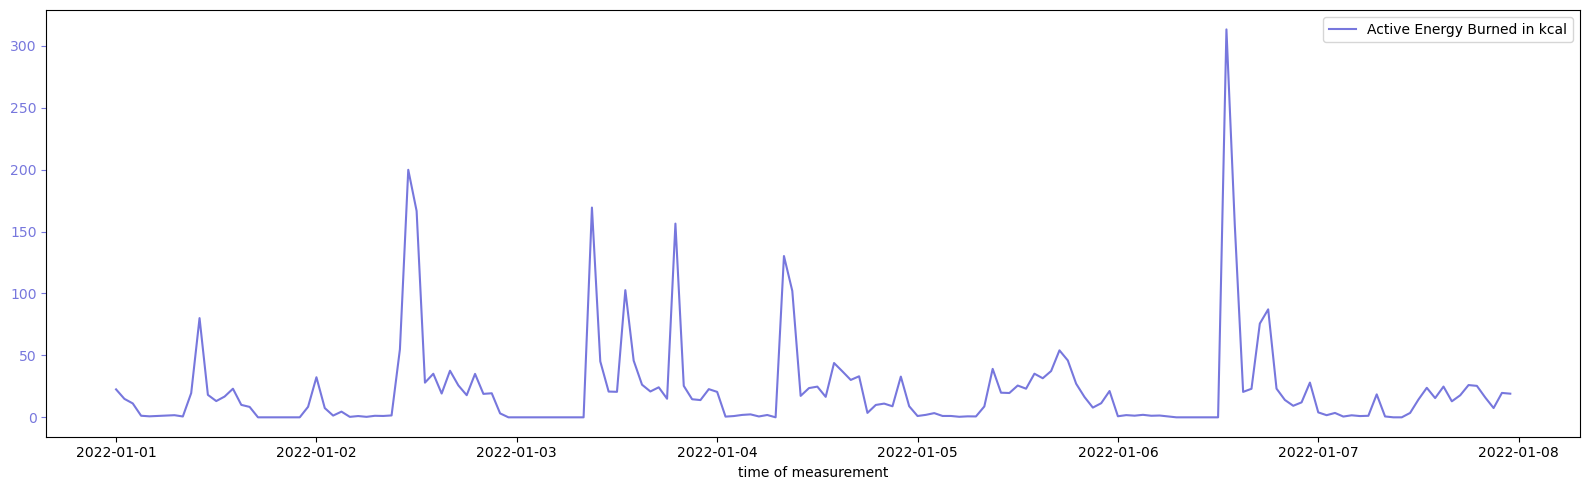

In [90]:
fig, ax = plot_variable(active_energy_burned, "Active Energy Burned")
fig

### Adding Noise

To enable further testing, we add some noise to our active_energy_burned variable. The first kind we add is Gaussian noise with mean zero. The second kind is salt and pepper noise, where there is a probability p that a measurement is lost and instead a very high (here we assume 350) or very low (here we will use 0) is measured. You can imagine the second type of noise for example as dead sensor elements or pixels in a camera.

In [92]:
# to add gaussian noise, we need to select a standard deviation 
std = active_energy_burned["value"].std()

# Here we will use the std of our variable with some multiplikative factor.
# Feel free to play around with the amount of noise. How do the later observations change?
sigma = 0.25 * std

# generate gausian noise
noise = np.random.normal(0, sigma, size=len(active_energy_burned))
active_energy_burned_gaussian = active_energy_burned.copy()
active_energy_burned_gaussian["value"] = active_energy_burned["value"] + noise


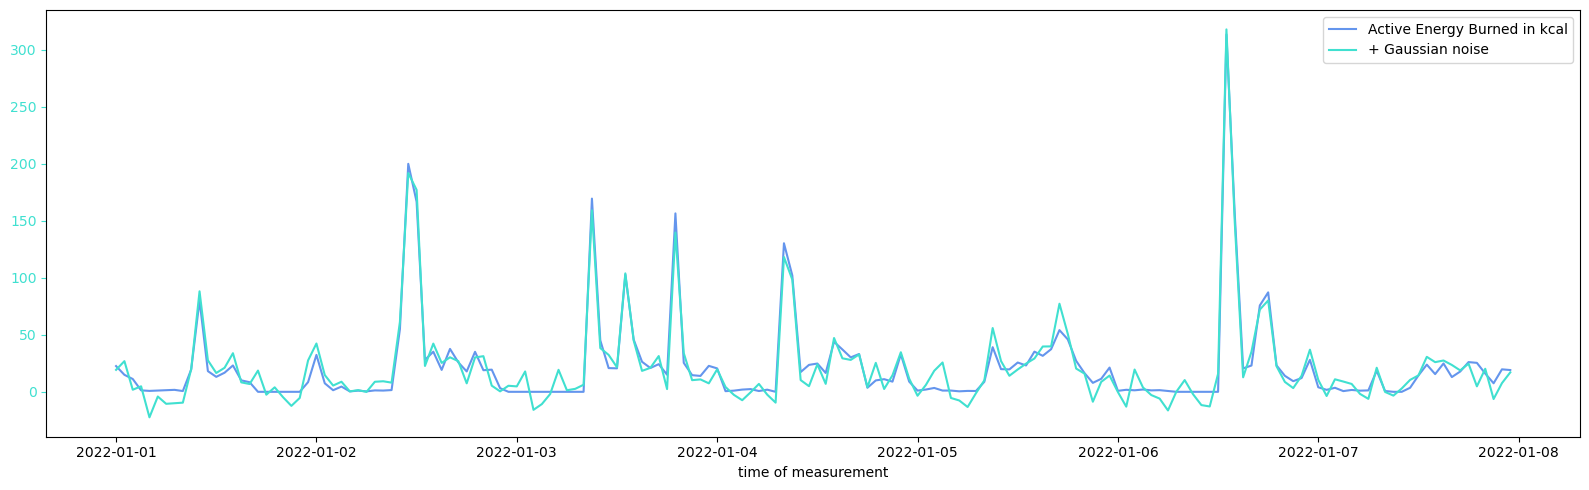

In [93]:
fig, ax = plot_variable(active_energy_burned, "Active Energy Burned")
fig, ax = plot_variable(active_energy_burned_gaussian, "+ Gaussian noise", append_unit=False, figax=(fig,ax), new_y=False)
fig

In [94]:
# for salt and pepper noise, we need to select some random indices with probability p
p = 0.1

noise_indices = np.random.choice(np.arange(len(active_energy_burned)), 
                                 size=int(p*len(active_energy_burned)),
                                 replace=False)

# generate the salt and pepper measurements with uniform probability
noise = np.random.choice([0, 350],
                         size=len(noise_indices))
active_energy_burned_snp = active_energy_burned.copy()

active_energy_burned_snp.loc[noise_indices,"value"] = noise
#active_energy_burned_snp

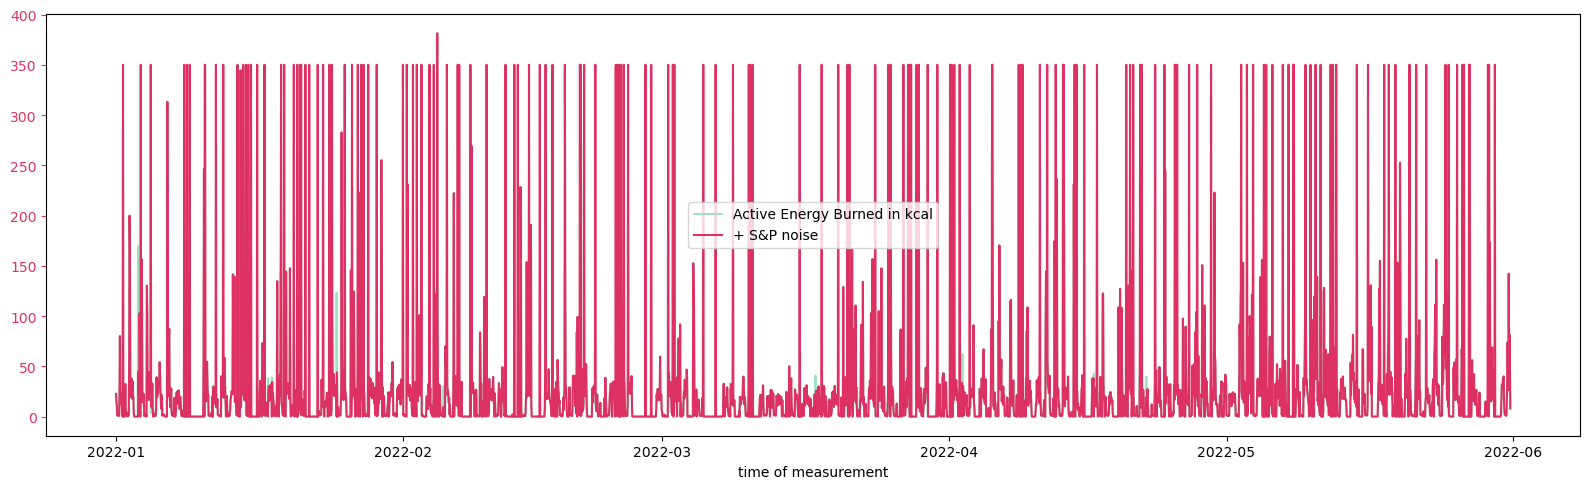

In [82]:
fig, ax = plot_variable(active_energy_burned, "Active Energy Burned")
fig, ax = plot_variable(active_energy_burned_snp, "+ S&P noise", append_unit=False, figax=(fig,ax), new_y=False)
fig

We now have three timeseries to implement and test filtering all of them contain exactly one measurement per hour for the first week of January 2022:
1. active_energy_burned ... the original data
2. active_energy_burned_gaussian ... + added Gaussian noise
3. active_energy_burned_snp ... some measurements are spikes or zero

## Tasks:

### Linear Filtering
1. implement a function that takes a in timeseries dataframe and a mask in the form of a vector and calculates the resulting convolution. How can you handle the start and end of the timeseries? (Hint 0-padding, mirroring, constant)
2. test your function with varying filter sizes and filters. You can use the snippets provided below to generate different filter masks. What are your observations?
    - What happens with the noisy signal compared to the original data?


In [95]:
###
# Some functions to generate filters
###
def gaussian_filter(size=7, sigma=1):
    """The gaussian filter is a lowpass, i.e., smoothing filter."""
    kern = gaussian(size, std=sigma)
    return kern/kern.sum()

def box_filter(size=7):
    """The box/average/mean filter is also a lowpass filter."""
    return np.ones(size)/size

def prewitt_filter():
    """The Prewitt filter is a highpass filter. Using this filter approximates the first derivative of the signal."""
    return np.array([-1,0,1])

In [102]:


from statistics import mode

def apply_linear_filter(df, filter):


    values = df['value'].values
    filtered_values = np.convolve(values, filter, mode='same')
    
# Apply padding to handle edges
    if mode == 'constant':
        padding = len(filter) // 2
        filtered_values[:padding] = 0
        filtered_values[-padding:] = 0
    elif mode == 'reflect':
        # Pad the start and end with reflected values
        filtered_values[:padding] = values[padding:0:-1]
        filtered_values[-padding:] = values[-2:-(padding+2):-1]
        
    # Return the DataFrame with the new filtered 'value' column
    return pd.DataFrame({"value": filtered_values}, index=df.index)


In [103]:
print("Values by Filter-Gaussian")
AEB_Gaus = apply_linear_filter(active_energy_burned, box_filter(size=7, sigma=1))  ## gaussian_filter   ## box_filter   ## prewitt_filter
#AEB_Gaus

AEB = active_energy_burned.take([0,1], axis=1)  ## DATA FRAME 
AEB_Gaus = pd.concat([AEB, AEB_Gaus],axis=1)
AEB = active_energy_burned.take([3], axis=1)  ## DATA FRAME 
AEB_Gaus = pd.concat([AEB_Gaus, AEB],axis=1)

AEB_Gaus



Values by Filter-Gaussian


TypeError: box_filter() got an unexpected keyword argument 'sigma'

In [99]:
print("Values by Filter-Gaussian nach dem gaussischen Noise")
AEB_Gaus_Noisy = apply_linear_filter(active_energy_burned_gaussian, gaussian_filter(size=7, sigma=1))
#AEB_Gaus_Noisy

AEB = active_energy_burned.take([0,1,], axis=1)  ## DATA FRAME 
AEB_Gaus_Noisy = pd.concat([AEB, AEB_Gaus_Noisy],axis=1)
AEB = active_energy_burned.take([3], axis=1)  ## DATA FRAME 
AEB_Gaus_Noisy = pd.concat([AEB_Gaus_Noisy, AEB],axis=1)
AEB_Gaus_Noisy


Values by Filter-Gaussian nach dem gaussischen Noise


,start,end,value,unit
0,2022-01-01 00:00:00,2022-01-01 00:00:00,14.307553,kcal
1,2022-01-01 01:00:00,2022-01-01 01:00:00,15.988955,kcal
2,2022-01-01 02:00:00,2022-01-01 02:00:00,8.219433,kcal
3,2022-01-01 03:00:00,2022-01-01 03:00:00,-1.770293,kcal
4,2022-01-01 04:00:00,2022-01-01 04:00:00,-9.143176,kcal
...,...,...,...,...
163,2022-01-07 19:00:00,2022-01-07 19:00:00,13.587906,kcal
164,2022-01-07 20:00:00,2022-01-07 20:00:00,9.596576,kcal
165,2022-01-07 21:00:00,2022-01-07 21:00:00,5.495978,kcal
166,2022-01-07 22:00:00,2022-01-07 22:00:00,6.743236,kcal


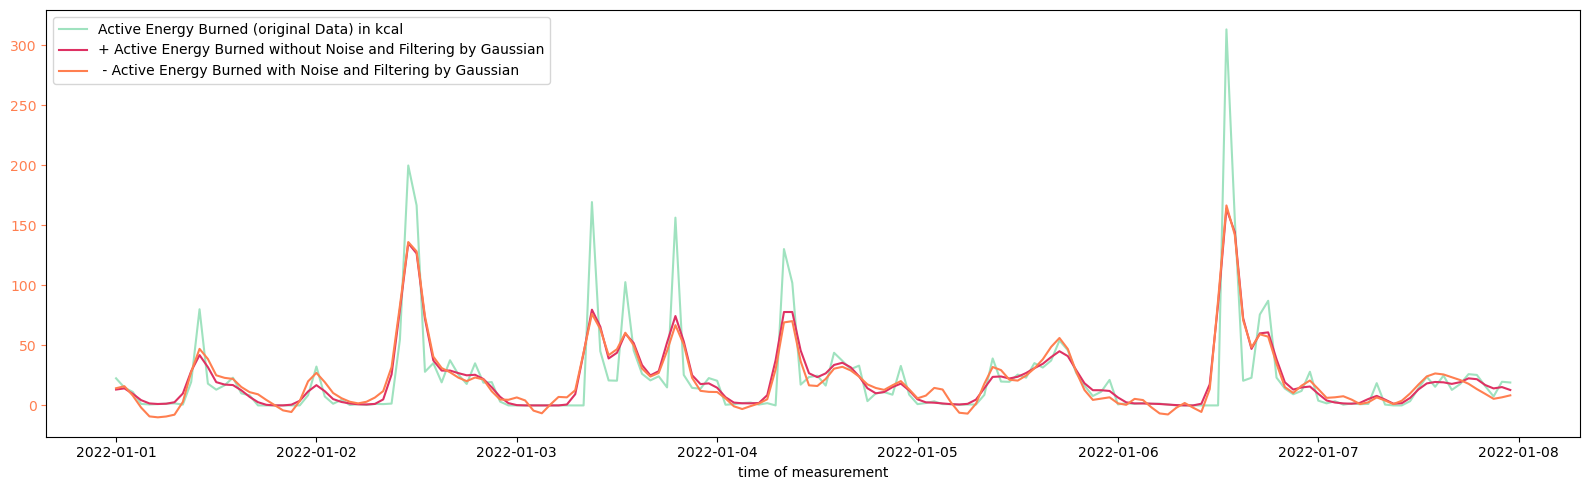

In [100]:
## Compare between original data and data with noise 
#! Filter: GAUSSIAN
active_energy_burned
fig, ax = plot_variable(active_energy_burned, "Active Energy Burned (original Data)")
fig, ax = plot_variable(AEB_Gaus, "+ Active Energy Burned without Noise and Filtering by Gaussian",append_unit=False, figax=(fig,ax), new_y=False)
fig, ax = plot_variable(AEB_Gaus_Noisy, " - Active Energy Burned with Noise and Filtering by Gaussian",append_unit=False, figax=(fig,ax), new_y=False)
fig

#AEB_Gaus_Noisy


In [68]:
print("Values by Box-Gaussian")
AEB_Box = apply_linear_filter(active_energy_burned, box_filter(size=7))
AEB_Box

Values by Box-Gaussian


,value
0,7.245571
1,9.022000
2,9.135857
3,9.195000
4,9.185571
...,...
40189,21.235000
40190,25.842286
40191,25.842286
40192,25.842286


In [ ]:
## Compare between original data and data with noise 

#! Filter: Box 

fig, ax = plot_variable()



In [ ]:
print("Values by Prewitt-Gaussian")
AEB_Prewitt = apply_linear_filter(active_energy_burned, prewitt_filter())
AEB_Prewitt

Values by Prewitt-Gaussian


,value
0,-13.390
1,-16.926
2,-5.817
3,5.089
4,18.410
...,...
40189,-29.586
40190,36.932
40191,2.153
40192,-4.904


In [ ]:
## Compare between original data and data with noise 

#! Filter: Prewitt

fig, ax = plot_variable()



Explain your observations. What happens to the noisy versions of our variable?

### Non-Linear Filtering
1. implement a function that takes in a timeseries dataframe, a filter size, and a non-linear filter function. The function should apply the nonlinear filter defined by the filter function.
2. test your function with varying filter sizes and filters. You can use the provided filter functions below. What are your observations?
    - What happens with the noisy signal compared to the original data?

In [52]:
###
# Some functions that define non-linear filters
###
def median_filter(values):
    """The median filter returns the median of the given values"""
    return np.median(values)

def min_filter(values):
    """The min filter returns the minimum of the given values"""
    return np.min(values)

def max_filter(values):
    """The max filter returns the maximum of the given values"""
    return np.max(values)

In [ ]:


def apply_nonlinear_filter(df, filter_func, filter_size):

    # Entnahme der 'Value' Column 
    values = df['value'].values
    # Ansatz der Filter
    filtered_values = filter_func(values, size=filter_size)
    
    # Neue DataFrame 
    return pd.DataFrame({"value": filtered_values}, index=df.index)

In [57]:
print("Values by Median Filter")
apply_nonlinear_filter(active_energy_burned, median_filter, filter_size=5) ## 

Values by Median Filter


TypeError: median_filter() got an unexpected keyword argument 'size'

In [ ]:
print("Values by Min Filter")
apply_nonlinear_filter(active_energy_burned, min_filter, filter_size=5)


In [ ]:
apply_nonlinear_filter(active_energy_burned, max_filter, filter_size=5)